In [1]:
import numpy as np
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import LinearColorMapper, BasicTicker, ColorBar
from bokeh.palettes import Category10
output_notebook()

Loading BokehJS ...

# Introduction to Gaussian Processes - Part I
Author: [@alex_bridgland](https://twitter.com/alex_bridgland) | [@bridgo](https://github.com/Bridgo)

Blog post: http://bridg.land/posts/gaussian-processes-1
***
Gaussian processes may not be at the center of current machine learning hype but are still used at the forefront of research -- they were recently seen automatically tuning the MCTS hyperparameters for AlphaGo Zero for instance. They manage to be very easy to use while providing rich modeling capacity and uncertainty estimates.

However they can be pretty hard to grasp, especially if you're used to the type of models we see a lot of in deep learning. So hopefully this guide can fix that! It assumes a fairly minimal ML background and I aimed for a more visual & intuitive introduction without totally abandoning the theory. To get the most out of it I recommend downloading the notebook and experimenting with all the code!

## What is a Gaussian Process and why would I use one?
***
A Gaussian process (GP) is a powerful model that can be used to represent a distribution over functions. Most modern techniques in machine learning tend to avoid this by parameterising functions and then modeling these parameters (e.g. the weights in linear regression). However GPs are nonparametric models that model the function directly. This comes with one hugely important benefit: not only can we model any black-box function, __we can also model our uncertainty__. Quantifying uncertainty can be extremely valuable - for example if we are allowed to explore (request more data) we can chose to explore the areas we are least certain about to be as efficient as possible. This is the main idea behind Bayesian optimisation. For more information on the importance of uncertainty modeling see [this article](http://mlg.eng.cam.ac.uk/yarin/blog_3d801aa532c1ce.html) by Yarin Gal.

> If you give me several pictures of cats and dogs – and then you ask me to classify a new cat photo – I should return a prediction with rather high confidence. But if you give me a photo of an ostrich and force my hand to decide if it's a cat or a dog – I better return a prediction with very low confidence.
>
> Yarin Gal

For this introduction we will consider a simple regression setup without noise (but GPs can be extended to multiple dimensions and noisy data):
- We assume there is some hidden function $f:\mathbb{R}\rightarrow\mathbb{R}$ that we want to model.
- We have data $\mathbf{x}=[x_ 1, \ldots, x_N]^T, \mathbf{y}=[y_ 1, \ldots, y_N]^T$ where $y_i = f(x_i)$.
- We want to predict the value of $f$ at some new, unobserved points $\mathbf{x}_*$.

## Modeling Functions using Gaussians
***
The key idea behind GPs is that a function can be modeled using an infinite dimensional multivariate Gaussian distribution. In other words, every point in the input space is associated with a random variable and the joint distribution of these is modeled as a multivariate Gaussian.

Ok, so what does that mean and what does it actually look like? Well lets start with a simpler case: a unit 2D Gaussian. How can we start to view this as a distribution over functions? Here's what we have:

$$ \begin{pmatrix} y_0 \\ y_1 \end{pmatrix} \sim\mathcal{N}\left(\begin{pmatrix} 0\\ 0 \end{pmatrix}, \begin{pmatrix} 1 & 0 \\ 0 & 1 \end{pmatrix}\right) $$

Normally this is visualised as a 3D bell curve with the probability density represented as height. But what if, instead of visualising the whole distribution, we just sample from the distribution. Then we will have two values which we can plot on an graph. Let's do this 10 times, putting the first value at $x=0$ and the second at $x=1$ and then drawing a line between them.

In [2]:
def plot_unit_gaussian_samples(D):
    p = figure(plot_width=800, plot_height=500, title='Samples from a unit {}D Gaussian'.format(D))

    xs = np.linspace(0, 1, D)
    for color in Category10[10]:
        ys = np.random.multivariate_normal(np.zeros(D), np.eye(D))
        p.line(xs, ys, line_width=1, color=color)
    return p

In [3]:
show(plot_unit_gaussian_samples(2))

Looking at all these lines on a graph, it starts to look like we've just sampled 10 linear functions... What if we now use a 20-dimensional Gaussian, joining each of the sampled points in order?

In [4]:
show(plot_unit_gaussian_samples(20))

These definitely look like functions of sorts but they look far too noisy to be useful for our purposes. Let's think a bit more about what we want from these samples and how we might change the distribution to get better looking samples...

The multivariate Gaussian has two parameters, its mean and covariance matrix. If we changed the mean then we would only change the overall trend (i.e. if the mean was ascending integers, e.g. `np.arange(D)` then the samples would have an overall positive linear trend) but there would still be that jagged noisy shape. For this reason we tend to leave the GP mean as zero - they actually turn out to be powerful enough to model many functions without changing this.

Instead we want some notion of _smoothness_: i.e. if two input points are close to each other then we expect the value of the function at those points to be similar. In terms of our model: random variables corresponding to nearby points should have similar values when sampled under their joint distribution (i.e. high _covariance_).

The covariance of these points is defined in the covariance matrix of the Gaussian. Suppose we have an $N$ dimensional Gaussian modeling $y_0,\ldots, y_N$, then the covariance matrix $\Sigma$ is $N\times N$ and its $(i, j)$-th element is $\Sigma_{ij}=\text{cov}(y_i, y_j)$. In other words $\Sigma$ is symmetric and stores the pairwise covariances of all the jointly modeled random variables.

## Smoothing with Kernels
***

So how should we define our covariance function? This is where the vast literature on kernels comes in handy. For our purposes we will choose a __squared exponential kernel__ which (in its simplest form) is defined by:

$$ \kappa(x, x')=\exp\left(-~\frac{(x-x')^2}{2}\right)$$

This function (which we plot in a moment) is 1 when $x=x'$ and tends to zero as its arguments drift apart.

In [5]:
def k(xs, ys, sigma=1, l=1):
    """Sqared Exponential kernel as above but designed to return the whole
    covariance matrix - i.e. the pairwise covariance of the vectors xs & ys.
    Also with two parameters which are discussed at the end."""

    # Pairwise difference matrix.
    dx = np.expand_dims(xs, 1) - np.expand_dims(ys, 0)
    return (sigma ** 2) * np.exp(-((dx / l) ** 2) / 2)

def m(x):
    """The mean function. As discussed, we can let the mean always be zero."""
    return np.zeros_like(x)

We can plot this kernel to show how it's maximised when $x=x'$ and then smoothly falls off as the two inputs start to differ.

In [6]:
N = 100
x = np.linspace(-2, 2, N)
y = np.linspace(-2, 2, N)
d = k(x, y)

color_mapper = LinearColorMapper(palette="Plasma256", low=0, high=1)

p = figure(plot_width=400, plot_height=400, x_range=(-2, 2), y_range=(-2, 2),
           title='Visualisation of k(x, x\')', x_axis_label='x', y_axis_label='x\'', toolbar_location=None)
p.image(image=[d], color_mapper=color_mapper, x=-2, y=-2, dw=4, dh=4)

color_bar = ColorBar(color_mapper=color_mapper, ticker=BasicTicker(),
                     label_standoff=12, border_line_color=None, location=(0,0))

p.add_layout(color_bar, 'right')

show(p)

So, to get the sort of smoothness we want we will consider two random variables $y_i$ and $y_j$ plotted at $x_i$ and $x_j$ to have covariance $\text{cov}(y_i, y_j)=\kappa(x_i, x_j)$ - _the closer they are together the higher their covariance_.

Using the kernel function from above we can get this matrix with `k(xs, xs)`. Now lets try plotting another 10 samples from the 20D Gaussian, but this time with the new covariance matrix. When we do this we get:

In [7]:
p = figure(plot_width=800, plot_height=500)
D = 20
xs = np.linspace(0, 1, D)
for color in Category10[10]:
    ys = np.random.multivariate_normal(m(xs), k(xs, xs))
    p.circle(xs, ys, size=3, color=color)
    p.line(xs, ys, line_width=1, color=color)

show(p)

Now we have something thats starting to look like a distribution over (useful) functions! And we can see how as the number of dimensions tends to infinity we don't have to connect points any more because we will have a point for every possible choice of input.

Let's use more dimensions and see what it looks like across a bigger range of inputs:

In [8]:
n = 100
xs = np.linspace(-5, 5, n)
K = k(xs, xs, sigma=1, l=1)
mu = m(xs)

In [9]:
p = figure(plot_width=800, plot_height=500)

for color in Category10[5]:
    ys = np.random.multivariate_normal(mu, K)
    p.line(xs, ys, line_width=2, color=color)
show(p)

## Making Predictions using the Prior & Observations
***
Now that we have a distribution over functions, how can we use training data to model a hidden function so that we can make predictions?

First of all we need some training data! And to get that we are going to create our secret function $f$.

### The Target Function $f$
For this intro we'll use a 5th order polynomial:

$$f(x)=0.03 x^5 + 0.2 x^4 - 0.1 x^3 - 2.4 x^2 - 2.5 x + 6$$

I chose this because it has a nice wiggly graph but we could have chosen anything (try changing `coefs` below, or `f(x)` entirely, to model different functions).

In [16]:
# coefs[i] is the coefficient of x^i
coefs = [6, -2.5, -2.4, -0.1, 0.2, 0.03]

def f(x):
    total = 0
    for exp, coef in enumerate(coefs):
        total += coef * (x ** exp)
    return total

In [17]:
xs = np.linspace(-5.0, 3.5, 100)
ys = f(xs)

In [18]:
p = figure(plot_width=800, plot_height=400, x_axis_label='x', y_axis_label='f(x)',
           title='The hidden function f(x)')
p.line(xs, ys, line_width=2)
show(p)

### Getting into the Maths

Now we get to the heart of GPs. Theres a bit more maths required but it only consists of consolidating what we have so far and using one trick to condition our joint distribution on observed data.

So far we have a way to model $p(\mathbf{y}\vert\mathbf{x})$ using a multivariate normal:

$$p(\mathbf{y}\vert\mathbf{x})=\mathcal{N}(\mathbf{y}\vert m(\mathbf{x}),\mathbf{K})$$

where $\mathbf{K}=\kappa(\mathbf{x}, \mathbf{x})$ and $m(\mathbf{x})=\mathbf{0}$.

This is a prior distribution representing the kind out outputs $\mathbf{y}$ that we expect to see over some inputs $\mathbf{x}$ _before_ we observe any data.

So we have some training data with inputs $\mathbf{x}$, and outputs $\mathbf{y}=f(\mathbf{x})$. Now lets say we have some new points $\mathbf{x}_*$ where we want to predict $\mathbf{y}_*=f(\mathbf{x}_*)$.

In [19]:
x_obs = np.array([-4, -1.5, 0, 1.5, 2.5, 2.7])
y_obs = f(x_obs)

x_s = np.linspace(-8, 7, 80)

Now recalling the definition of a GP, we will model the joint distribution of all of $\mathbf{y}$ and $\mathbf{y}_*$ as:

$$ \begin{pmatrix}\mathbf{y} \\ \mathbf{y}_*\end{pmatrix} \sim\mathcal{N}\left(\begin{pmatrix}m(\mathbf{x})\\ m(\mathbf{x}_*)\end{pmatrix}, \begin{pmatrix}\mathbf{K} & \mathbf{K}_* \\ \mathbf{K}_*^T & \mathbf{K}_{**}\end{pmatrix}\right) $$

where $\mathbf{K}=\kappa(\mathbf{x}, \mathbf{x})$, $\mathbf{K}_* = \kappa(\mathbf{x}, \mathbf{x}_*)$ and $\mathbf{K}_{**}=\kappa(\mathbf{x}_*, \mathbf{x}_*)$. As before we are going to stick with a zero mean.

However this is modeling $p(\mathbf{y}, \mathbf{y}_*\vert \mathbf{x}, \mathbf{x}_*)$ and we only want a distribution over $\mathbf{y}_*$!

### Conditioning Multivariate Gaussians

Rather than deriving it from scratch we can just make use of [this standard result](https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Conditional_distributions). If we have a joint distribution over $\mathbf{y}$ and $\mathbf{y}_*$ as above, and we want to condition on the data we have for $\mathbf{y}$ then we have the following:

$$\begin{align}
p(\mathbf{y}_*\vert \mathbf{x}_*, \mathbf{x}, \mathbf{y})&=\mathcal{N}(\mathbf{y}_*\vert \mu_*, \Sigma_*)\\
\mu_*&=m(\mathbf{x}_*)+\mathbf{K}_*^T\mathbf{K}^{-1}(\mathbf{y}-m(\mathbf{x}))\\
\Sigma_*&=\mathbf{K}_{**}-\mathbf{K}_*^T\mathbf{K}^{-1}\mathbf{K}_*
\end{align}$$

Now we have a posterior distribution over $\mathbf{y}_*$ using a prior distribution and some observations!

_NB: The code below would not be used in practice since \\( \mathbf{K} \\) can often be poorly conditioned, so its inverse might be inaccurate. A better approach is covered in part II of this guide!_

In [21]:
K = k(x_obs, x_obs)
K_s = k(x_obs, x_s)
K_ss = k(x_s, x_s)

K_sTKinv = np.matmul(K_s.T, np.linalg.pinv(K))

mu_s = m(x_s) + np.matmul(K_sTKinv, y_obs - m(x_obs))
Sigma_s = K_ss - np.matmul(K_sTKinv, K_s)

And that's it! We can now use these two parameters to draw samples from the conditional distribution. Here we plot them against the true function $f(x)$ (the dashed black line). Since we are using a GP we also have uncertainty information in the form of the variance of each random variable. We know the variance of the $i$-th will be ${\Sigma_*}_{ii}$ - in other words the variances are just the diagonal elements of $\Sigma_*$. Here we plot the samples with an uncertainty of $\pm 2$ standard deviations.

In [22]:
p = figure(plot_width=800, plot_height=600, y_range=(-7, 8))

y_true = f(x_s)
p.line(x_s, y_true, line_width=3, color='black', alpha=0.4, line_dash='dashed', legend='True f(x)')

p.cross(x_obs, y_obs, size=20, legend='Training data')

stds = np.sqrt(Sigma_s.diagonal())
err_xs = np.concatenate((x_s, np.flip(x_s, 0)))
err_ys = np.concatenate((mu_s + 2 * stds, np.flip(mu_s - 2 * stds, 0)))
p.patch(err_xs, err_ys, alpha=0.2, line_width=0, color='grey', legend='Uncertainty')

for color in Category10[3]:
    y_s = np.random.multivariate_normal(mu_s, Sigma_s)
    p.line(x_s, y_s, line_width=1, color=color)
    
p.line(x_s, mu_s, line_width=3, color='blue', alpha=0.4, legend='Mean')
show(p)

## What next? - GP Regression and Noisy Data
***
In practice we need to do a bit more work to get good predictions. You may have noticed that the kernel implementation contained two parameters $\sigma$ and $l$. If you try changing those when sampling from the prior then you can see how $\sigma$ changes the vertical variation and $l$ changes the horizontal scale. So we would need to change these to reflect our prior belief about the hidden function $f$. For instance if we expect $f$ to have a much bigger range of outputs (for the domain we are interested in) then we would need to scale up $\sigma$ accordingly (try scaling the return value of $f$ by 100 to see what happens, then set `sigma=100`). In fact, as with anything that uses kernels, we might change our kernel entirely if we expect a different kind of function (e.g. a periodic function).

Picking the kernel is up to a human expert but choosing the parameters can be done automatically by minimizing a loss term. This is the realm of Gaussian process regression. 

Finally we should consider how to handle noisy data - i.e. when we can't get perfect samples of the hidden function $f$. In this case we need to factor this uncertainty into the model to get better generalisation.

These two topics will be the focus of _Introduction to Gaussian Processes - Part II_.

## Resources
***
- _Machine Learning - A Probabilistic Perspective_, Chapter 15 by Kevin P. Murphy
- [Introduction to Gaussian processes](https://www.youtube.com/watch?v=4vGiHC35j9s) on YouTube by Nando de Freitas

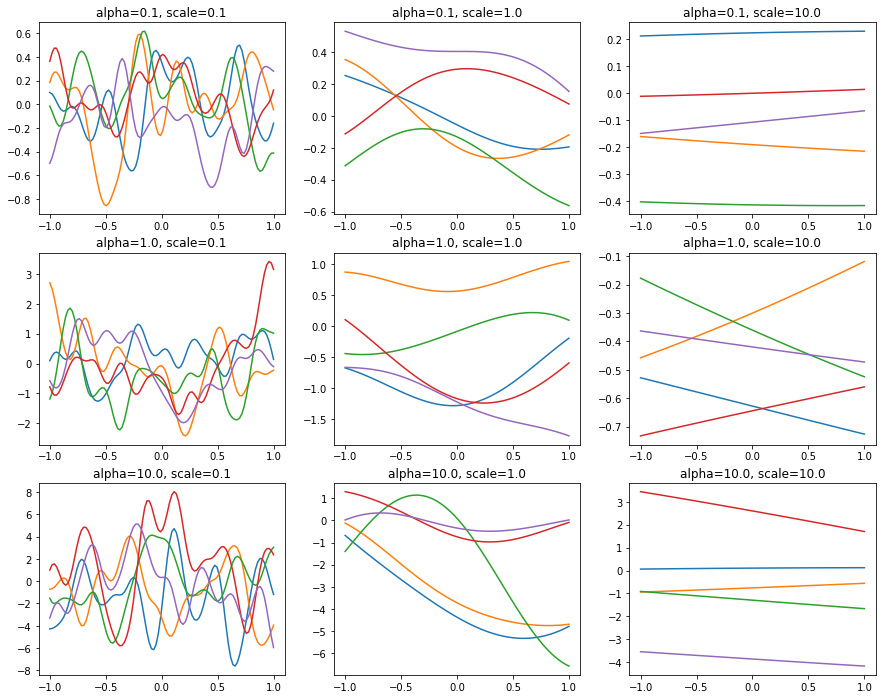

In [11]:
import numpy as np
from sklearn.gaussian_process.kernels import RBF
from matplotlib import pyplot as plt

n_points = 100
plt.figure(figsize=(15, 12))
for i, alpha in enumerate([0.1, 1.0, 10.0]):
    for j, scale in enumerate([0.1, 1.0, 10.0]):
        plt.subplot(3, 3, i * 3 + j + 1)
        x = np.linspace(-1.0, 1.0, n_points)
        mu = np.zeros(n_points)
        kernel = alpha * RBF(length_scale=scale)
        cov = kernel(x.reshape((-1, 1)))
        for k in range(5):
            y = np.random.multivariate_normal(mu, cov)
            plt.plot(x, y)
        plt.title("alpha={:.1f}, scale={:.1f}".format(alpha, scale))
plt.show()

# 隨著$l$逐漸變大，函數變得平滑；隨著$\sigma$逐漸變大，函數的採樣值範圍變大